# Image Classification using Logistic Regression

In this lab, we will be using logistic regression to classify sample images, to identify which digit, from 0 to 9, each input image resembles. Logistic Regression is one of the models for supervised learning. In supervised learning
- The input data used for training contains a label that correctly identifies the data
- After training, the model may be used to predict the label for an unknown data point.

## Introduction to Logistic Regression

![Logistic Regression Model](images/LogisticRegressionModel.jpg)

In logistic regression, the output of the model is either 0, or 1, meaning it is only able to classify a binary relationship. For example, is the input an image of the digit 0?

Each input data point is a set of features, `X0, X1, ... , Xn`.  The model contains weights `w0, w1, ..., wn`. The output of the model is calculated as:
- First calculate `y = w0*1 + w1*X1 + w2*X2 + ... + wn*Xn`
- Apply an activation function to normalize y to a value beween 0 and 1. This is also the probability that the output label is 1.
- Apply a threshold function to determine whether the output is 0 or 1. In our example, the output is 1 if y >= 0.5.

To train the model, we feed it a sufficiently representative set of input data whose output should be 1. **Given a set of input  data, the training is used to calculate the values of the weights `w0, w1, .. wn.` such that they "best fit" the training data. This is an optimization problem with n parameters.**  Intuitively, the weights are calculated such that the output is 1 for all the input data, and for all other data "similar" to the input data. How this is done is beyond the scope of this lab.

Note that logistic regression is closely related to linear regression. Let's remove the activation and threshold functions, and just look at the summation.  In the case of just one varible, it reduces to `y = 1*w0 + w1* X1`, which is exactly the form of `y = b + mx`.

After the model has been trained, it may be used to classify new data. Given an unknown input data, the model uses the trained weights to derive the output for the new data, to classify it as either 0 or 1.  


## Explore the Image Data

We will be using the Modified National Institute of Standards (MNIST) data set, which contains 70,000 28x28 images of hand written digits. The first 60,000 are meant for training, while the last 10,000 are for testing. 
Let's first load the data, and look at the first 15 sample images.

In [1]:
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
mnist = fetch_openml('mnist_784', version=1)
# This will train the MNIST Fashion images instead.
# mnist = fetch_openml('Fashion-Mnist', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X = mnist['data'] # Each X[i] is a 28x28 image
y = mnist['target'] # Each y[i] is a digit, 0-9
print ('x:', X.shape, 'y:', y.shape)

x: (70000, 784) y: (70000,)


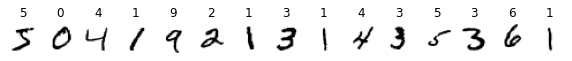

In [4]:
# Display the first 15 images, and their respective labels
numDigits = 15
plt.figure(figsize=(10, 1))
for idx in range(numDigits):
  plt.subplot(1, numDigits, idx+1)
  digit = X[idx:idx+1].to_numpy()
  image = digit.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.title(y[idx])
  plt.axis("off")

plt.show()

##  How to Train Our Data

There are two issues we need to address when using logistic regression for our data set:
- How to map the image data to features to be trained.
- How to classify a digit as between 0 and 9, when a logistic regression model is a binary classifier.

For the first issue, the information content for an image is in the pixels. Therefore, we map each pixel into a feature. This means that there are 28x28= 784 features for our model. 

We resolve the second issue by using 10 different models, one for each digit. For each data point in the training set, if the digit is 0, it is fed to the model for 0 for training.  If it is the digit 1, it is fed to the model for 1, and so on.   

After training, in order to decide which digit a test image resembles, we feed the image to all models, and pick the one that has the highest value for its activation function.  This is shown below:

![Making a Prediction](images/PredictImage.jpg)


## Choosing the Training and Test Sets

To reduce the amount of time needed to train the model, we will use only 10000 data points for training.  We will also choose a test set of 10,000 data points.

In [5]:
X_train, X_test, y_train, y_test = X[:10000], X[60000:], y[:10000].to_numpy(), y[60000:].to_numpy()

## Data Normalization

The training algorithm works better when the data is normalized. Since each pixel value is maximum of 255, dividing each pixel value by 255 normalizes the data to a range between 0 and 1.

In [6]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

## Train the Model

This is easily accomplished using sklearn's LogisticRegression. Note that it automatically creates multiple models based on the number of label values in variable `y_train`.

In [7]:
lr = LogisticRegression(solver='saga', tol=0.1)
lr.fit(X_train_scaled, y_train)

LogisticRegression(solver='saga', tol=0.1)

## Test the first 20 digits in the test set

Let's sniff test the first 20 digits of the test set, and show the output. Note that the model does not make the correct prediction 100% of the time. Where the predicted result id wrong, we show the output in red.

In [8]:
numTestDigits = 20
predicted_digits = lr.predict(X_test_scaled[0:numTestDigits])

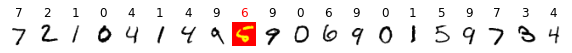

In [9]:
plt.figure(figsize=(10, 1))
for idx in range(numTestDigits):
  plt.subplot(1, numTestDigits, idx+1)
  digit = X_test[idx:idx+1].to_numpy()
  image = digit.reshape(28,28)
  fontColor = 'black'
  colorMap = 'binary'
  if predicted_digits[idx] != y_test[idx] :
    fontColor = 'red'
    colorMap = 'autumn'
  plt.imshow(image, cmap= colorMap)
  plt.title(predicted_digits[idx], fontdict={ 'color': fontColor })
  plt.axis("off")

plt.show()

## Plot the Trained Weights for Each Model

As a linear model, the value of the weights can give us insight into how the model is able to predict a digit. In the plot below, the bright pixels have higher weight, while the dark spots have lower weight. For many of the models, you can see an outline for the digit that it is trained to classify. 

In [10]:
# Note that their are 10 models, each with 784 weights.
lr.coef_.shape

(10, 784)

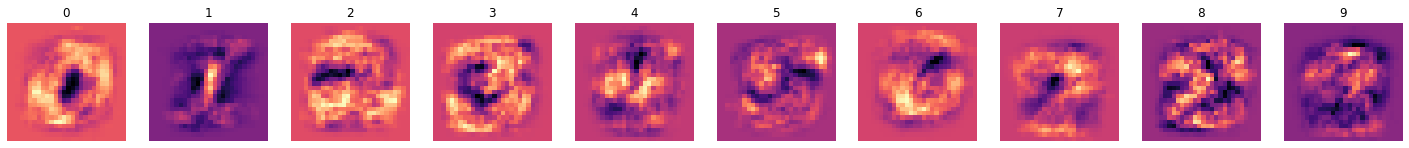

In [11]:
# Plot the weights
numWeightDigits = 10
plt.figure(figsize=(25, 2.5))
for idx in range(numWeightDigits):
    plt.subplot(1, numWeightDigits, idx+1)
    plt.imshow(lr.coef_[idx].reshape(28, 28),
                  cmap=plt.cm.magma);
    plt.axis('off')
    plt.title(idx);

plt.show()

## Plot the Values of Activation Functions for One Test Image

Recall that in the case of muti-class classification, the threshold function uses the largest of the individual model's activation function.  Let's calculate and plot it for one test iamge.

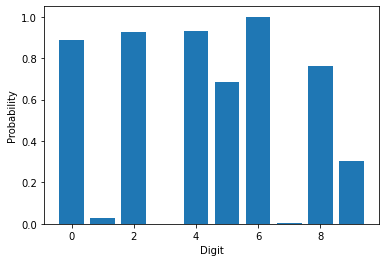

In [12]:
# Get one of the test images
test_image_index = 8
test_image = (X_test_scaled[test_image_index:test_image_index+1].to_numpy())[0]

# Calculate y = w0 +  w1*X1 + ... + wn*Xn for all 10 models
y = [ lr.intercept_[idx] + numpy.dot(lr.coef_[idx], test_image) for idx in range(10) ]

# Calcuate the activation function for all 10 models
exponentials = [numpy.exp(y[idx]) for idx in range(10)]
activation = exponentials / (numpy.add(exponentials,  1)) # sigmoid function = exp(y)/(exp(y)+1)

#plot
plt.bar( numpy.arange(0,10), activation);
plt.ylabel("Probability");
plt.xlabel("Digit");
plt.show()

## Find the Accuracy of the Model

The accuracy is the percentage of the test data correctly predicted by the model.

In [13]:
accuracy = lr.score(X_test_scaled, y_test)
print(accuracy)

0.9115


## Discussions and Additional Activities

- Re-run the lab with the [Fashion-Mnist](https://www.openml.org/d/40996) data set to classify different types of clothing. It contains the same number of images and the same image size as the hand writing digits data set. The labels of the data are:
    - 0  T-shirt/top  
    - 1  Trouser  
    - 2  Pullover  
    - 3  Dress  
    - 4  Coat  
    - 5  Sandal  
    - 6  Shirt  
    - 7  Sneaker  
    - 8  Bag  
    - 9  Ankle boot  
- If you had to code an algorithm to detect digits, what would that algorithm look like? Would it be applicable to detecting different types of clothing?
- Read about [Logistics Regression](https://en.wikipedia.org/wiki/Logistic_regression) in detail.
- Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) as other metrics to evaluate your model.